In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
import matplotlib.pyplot as plt
from pylib.utils.functions_for_classification import mixed_2d_2cls, plot_scatter

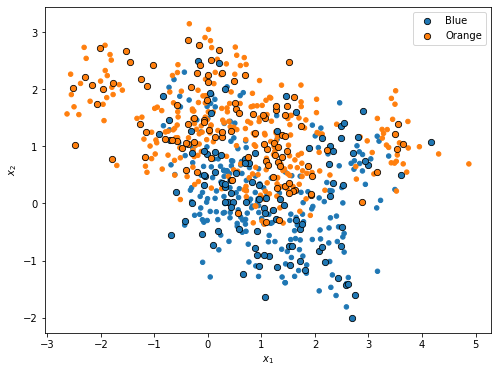

In [3]:
X_train, X_test, y_train, y_test = mixed_2d_2cls()
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train, X_test, y_test)
plt.show()

## 最小二乘提升

In [4]:
from pylib.utils.functions_for_classification import plot_decision_boundary
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy
import numpy as np

In [5]:
class L2Boosting(BaseEstimator, ClassifierMixin):
    """
    最小二乘提升
    
    参数
    ----
    base_estimator: 基本学习器，一般使用简单的回归树
    n_estimators: 基本学习器的数量
    learning_rate: 每个基本学习器的权重，也叫学习率
    
    属性
    ----
    loss_history: 存储历史的损失值
    """
    def __init__(self, base_estimator=DecisionTreeRegressor(max_depth=3),
                 n_estimators=100, learning_rate=0.1):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate

    def fit(self, X, y):
        y = np.where(y >= 1, 1, -1)
        self.base_learners = []
        self.y_mean = np.mean(y)
        ym1_pred = np.repeat(self.y_mean, len(X))
        self.estimators = []
        self.loss_history = []
        for m in range(self.n_estimators):
            r = y - ym1_pred
            mse = np.sqrt(np.sum(r**2))  # 计算均方根误差
            self.loss_history.append(mse)
            base_learner = deepcopy(self.base_estimator)
            base_learner.fit(X, r)
            ym_pred = base_learner.predict(X)
            ym1_pred = ym1_pred + self.learning_rate * ym_pred  #  更新
            self.estimators.append(base_learner)

        return self

    def predict(self, X):
        ym1_pred = np.repeat(self.y_mean, len(X))
        for learner in self.estimators:
            ym_pred = learner.predict(X)
            ym1_pred = ym1_pred + self.learning_rate * ym_pred
        ym1_pred = np.where(ym1_pred > 0, 1, 0)
            
        return ym1_pred

In [6]:
l2boost = L2Boosting()
l2boost.fit(X_train, y_train)

L2Boosting(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=3,
                                                max_features=None,
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                presort=False,
                                                random_state=None,
                                                splitter='best'),
           learning_rate=0.1, n_estimators=100)

In [7]:
train_err = 1 - l2boost.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.015


In [8]:
test_err = 1 - l2boost.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.262


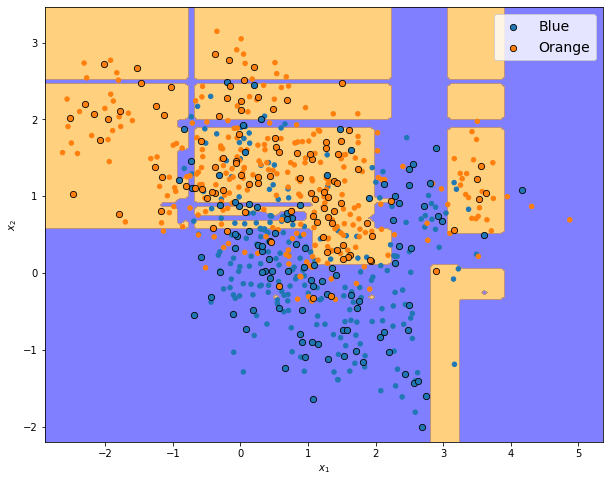

In [76]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, l2boost)
plt.show()

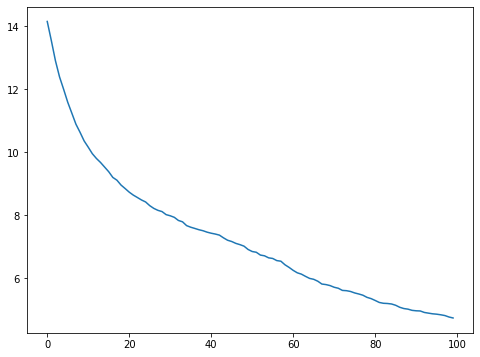

In [9]:
# 绘制历史损失值
loss_history = l2boost.loss_history
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_history)), loss_history)
plt.show()

### 寻找最优参数

In [84]:
from sklearn.model_selection import GridSearchCV

In [85]:
param_grid = {
    'base_estimator__max_depth': [3, 5, 10, 20],
    'base_estimator__min_samples_leaf': [5, 10, 20, 30, 40],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1.0]
}
l2boost_cv = GridSearchCV(
    L2Boosting(base_estimator=DecisionTreeRegressor(random_state=42)),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1)
l2boost_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=L2Boosting(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                       max_depth=None,
                                                                       max_features=None,
                                                                       max_leaf_nodes=None,
                                                                       min_impurity_decrease=0.0,
                                                                       min_impurity_split=None,
                                                                       min_samples_leaf=1,
                                                                       min_samples_split=2,
                                                                       min_weight_fraction_leaf=0.0,
                                                                       presort=False,
                          

In [90]:
l2boost_cv.best_params_

{'base_estimator__max_depth': 3,
 'base_estimator__min_samples_leaf': 5,
 'learning_rate': 0.05,
 'n_estimators': 50}

### 使用最优参数模型

In [91]:
l2boost_best = l2boost_cv.best_estimator_

In [92]:
train_err = 1 - l2boost_best.score(X_train, y_train)
print("训练样本误差: {:.3f}".format(train_err))

训练样本误差: 0.115


In [93]:
test_err = 1 - l2boost_best.score(X_test, y_test)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.240


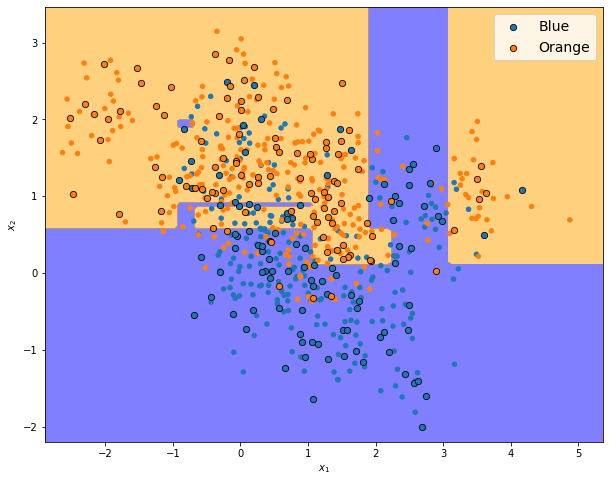

In [94]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, l2boost_best)
plt.show()

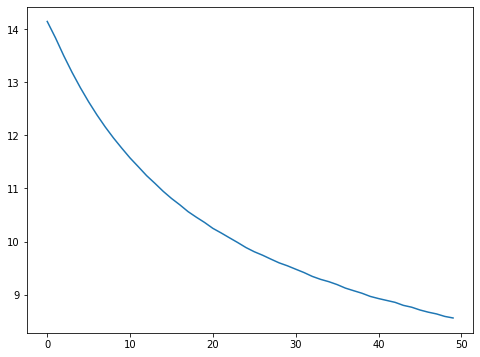

In [95]:
# 绘制历史损失值
loss_history = l2boost_best.loss_history
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_history)), loss_history)
plt.show()